# Automation

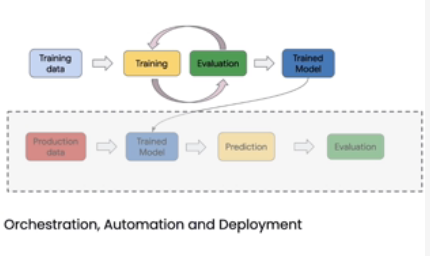

- You will use [Kubeflow Pipelines](https://www.kubeflow.org/docs/components/pipelines/v2/) to orchestrat and automate a workflow. 
- Kubeflow Pipelines is an open source framework. It's like a construction kit for building machine learning pipelines, making it easy to orchestrate and automate complex tasks. 

In [1]:
from kfp import dsl
from kfp import compiler

# Ignore FutureWarnings in kfp
import warnings
warnings.filterwarnings("ignore", 
                        category=FutureWarning, 
                        module='kfp.*')

## Kubeflow Pipelines

- Kubeflow pipelines consist of two key concepts: Components and pipelines.
- Pipeline components are like self-contained sets of code that perform various steps in your ML workflow, such as, the first step could be preprocessing data, and second step could betraining a model.

### Simple Pipeline Example 

##### Build the pipeline

In [2]:
### Simple example: component 1
@dsl.component
def say_hello(name: str) -> str:
    hello_text = f'Hello, {name}!'
    
    return hello_text

- Since we "wrapped" this `say_hello` function in the decorator `@dsl.component`, the function will not actually return a string.
- The function will return a `PipelineTask` object.

In [3]:
hello_task = say_hello(name="Erwin")
print(hello_task)

- The object that we'll use to pass the information in `hello_text` to other components in the pipeline is `PipelineTask.output`, which will be a built-in data type:
> `['String', 'Integer', 'Float', 'Boolean', 'List', 'Dict']`

In [4]:
print(hello_task.output)

{{channel:task=say-hello;name=Output;type=String;}}


- Note when passing in values to the a `dsl.component` function, you have to specify the argument names (keyword arguments), and can't use positional arguments.

In [6]:
# this will give an error and ask you to specify the parameter name
hello_task = say_hello("Erwin")

- The second component is dependent on the first component
- Take the output of the first component and pass it to the second component.

In [7]:
### Simple example: component 2
@dsl.component
def how_are_you(hello_text: str) -> str:
    
    how_are_you = f"{hello_text}. How are you?"
    
    return how_are_you

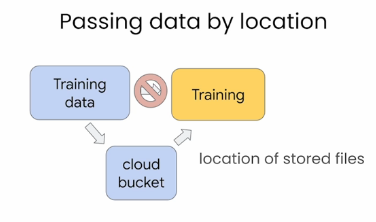

- Notice that when we pass in the return value from the `say_hello` function, we want to pass in the PipelineTask.output object, and not the PipelineTask object itself.

In [8]:
how_task = how_are_you(hello_text=hello_task.output)
print(how_task)
print(how_task.output)

{{channel:task=how-are-you;name=Output;type=String;}}


In [10]:
# This will give an error and ask you to pass in a built-in data type
how_task = how_are_you(hello_text=hello_task)
print(how_task)
print(how_task.output)

- Define the pipeline.
- Notice how the input to `say_hello` is just `recipient`, since that is already a built-in data type (a String).
- Recall that to get the value from a PipelineTask object, you'll use `PipelineTask.output` to pass in that value to another Pipeline Component function.
- Notice that Pipeline function should return the PipelineTask.output as well.

In [11]:
### Simple example: pipeline
@dsl.pipeline
def hello_pipeline(recipient: str) -> str:
    
    # notice, just recipient and not recipient.output
    hello_task = say_hello(name=recipient)
    
    # notice .output
    how_task = how_are_you(hello_text=hello_task.output)
    
    # notice .output
    return how_task.output 

- If you run this pipeline function, you'll see that the return value (`task.output` was a String) is again wrapped inside a PipelineTask object.

In [12]:
pipeline_output = hello_pipeline(recipient="Erwin")
print(pipeline_output)

- Note that if you tried to return a PipelineTask object instead of the PipelineTask.output, you'd get an error message

In [14]:
### Pipeline with wrong return value type
@dsl.pipeline
def hello_pipeline_with_error(recipient: str) -> str:
    hello_task = say_hello(name=recipient)
    how_task = how_are_you(hello_text=hello_task.output)

    return how_task 
    # returning the PipelineTask object itself will give you an error
        

##### Implement the pipeline

- A pipeline is a set of components that you orchestrate.
- It lets you define the order of execution and how data flows from one step to another.
- Compile the pipeline into a yaml file, `pipeline.yaml`
- You can look at the `pipeline.yaml` file in your workspace by going to `File --> Open...`. Or right here in the notebook (two cells below)

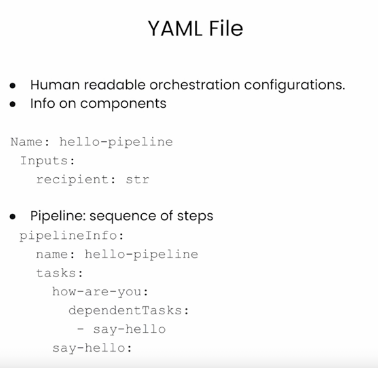

In [15]:
compiler.Compiler().compile(hello_pipeline, 'pipeline.yaml')

- Define the arguments, the input that goes into the pipeline.

In [16]:
pipeline_arguments = {
    "recipient": "World!",
}

- View the `pipeline.yaml`

In [18]:
!cat pipeline.yaml

# PIPELINE DEFINITION
# Name: hello-pipeline
# Inputs:
#    recipient: str
# Outputs:
#    Output: str
components:
  comp-how-are-you:
    executorLabel: exec-how-are-you
    inputDefinitions:
      parameters:
        hello_text:
          parameterType: STRING
    outputDefinitions:
      parameters:
        Output:
          parameterType: STRING
  comp-say-hello:
    executorLabel: exec-say-hello
    inputDefinitions:
      parameters:
        name:
          parameterType: STRING
    outputDefinitions:
      parameters:
        Output:
          parameterType: STRING
deploymentSpec:
  executors:
    exec-how-are-you:
      container:
        args:
        - --executor_input
        - '{{$}}'
        - --function_to_execute
        - how_are_you
        command:
        - sh
        - -c
        - "\nif ! [ -x \"$(command -v pip)\" ]; then\n    python3 -m ensurepip ||\
          \ python3 -m ensurepip --user || apt-get install python3-pip\nfi\n\nPIP_DISABLE_PIP_VERSION_CHECK=1\
   

- You can use [Vertex AI pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction), a *managed*, serverless environment, to execute the yaml files.

**Note**: Due to classroom restrictions, the execution will not take place in this notebook. But, if you were to execute it in your own environment, the code is provided below (for the simple example from above):

```python
### import `PipelineJob` 
from google.cloud.aiplatform import PipelineJob

job = PipelineJob(
        ### path of the yaml file to execute
        template_path="pipeline.yaml",
        ### name of the pipeline
        display_name=f"deep_learning_ai_pipeline",
        ### pipeline arguments (inputs)
        ### {"recipient": "World!"} for this example
        parameter_values=pipeline_arguments,
        ### region of execution
        location="us-central1",
        ### root is where temporary files are being 
        ### stored by the execution engine
        pipeline_root="./",
)

### submit for execution
job.submit()

### check to see the status of the job
job.state
```

- This is how the "hello world pipeline" would look like:

For **say_hello**

<div style="text-align: center;">
    <img src="./images/hello-world-pipeline_1.png" width="511" height="211"/>
</div>

For **how_are_you**

<div style="text-align: center;">
    <img src="./images/hello-world-pipeline_2.png" width="511" height="211"/>
</div>

### Real-life Pipeline Example 

#### Automation and Orchestration of a Supervised Tuning Pipeline.

- Reuse an existing Kubeflow Pipeline for Parameter-Efficient Fine-Tuning (PEFT) for a foundation model from Google, called [PaLM 2](https://ai.google/discover/palm2/). 
- Advantage of reusing a pipleline means you do not have to build it from scratch, you can only specify some of the parameters.

In [19]:
### these are the same 
### jsonl files from the previous lab

### time stamps have been removed so that 
### the files are consistent for all learners
TRAINING_DATA_URI = "./tune_data_stack_overflow_python_qa.jsonl" 
EVAUATION_DATA_URI = "./tune_eval_data_stack_overflow_python_qa.jsonl"  

- Provide the model with a version.
- Versioning model allows for:
  - Reproducibility: Reproduce your results and ensure your models perform as expected.
  - Auditing: Track changes to your models.
  - Rollbacks: Roll back to a previous version of your model.

In [21]:
### path to the pipeline file to reuse
### the file is provided in your workspace as well
template_path = 'https://us-kfp.pkg.dev/ml-pipeline/\
large-language-model-pipelines/tune-large-model/v2.0.0'

In [22]:
import datetime

In [23]:
date = datetime.datetime.now().strftime("%H:%d:%m:%Y")

In [24]:
MODEL_NAME = f"deep-learning-ai-model-{date}"

- This example uses two PaLM model parameters:
  - `TRAINING_STEPS`: Number of training steps to use when tuning the model. For extractive QA you can set it from 100-500. 
  - `EVALUATION_INTERVAL`: The interval determines how frequently a trained model is evaluated against the created *evaluation set* to assess its performance and identify issues. Default will be 20, which means after every 20 training steps, the model is evaluated on the evaluation dataset.

In [25]:
TRAINING_STEPS = 200
EVALUATION_INTERVAL = 20

- Load the Project ID and credentials

In [26]:
from utils import authenticate
credentials, PROJECT_ID = authenticate() 

In [27]:
REGION = "us-central1"

- Define the arguments, the input that goes into the pipeline.

In [28]:
pipeline_arguments = {
    "model_display_name": MODEL_NAME,
    "location": REGION,
    "large_model_reference": "text-bison@001",
    "project": PROJECT_ID,
    "train_steps": TRAINING_STEPS,
    "dataset_uri": TRAINING_DATA_URI,
    "evaluation_interval": EVALUATION_INTERVAL,
    "evaluation_data_uri": EVAUATION_DATA_URI,
}

In [37]:
from IPython.display import FileLink

# List of files you want to download
files_to_download = ['L3_automation.ipynb', 'pipeline.yaml', 'utils.py']

# Create download links for each file
for file_name in files_to_download:
    display(FileLink(file_name))



/home/jovyan/work/L3_automation.ipynb

/home/jovyan/work/pipeline.yaml

/home/jovyan/work/utils.py

In [ ]:
%%writefile utils


import os
from dotenv import load_dotenv
import json
import base64
from google.auth.transport.requests import Request
from google.oauth2.service_account import Credentials

def authenticate():
    return "DLAI_CREDENTIALS", "DLAI_PROJECT_ID"
    #Load .env
    load_dotenv()
    
    #Decode key and store in .JSON
    SERVICE_ACCOUNT_KEY_STRING_B64 = os.getenv('SERVICE_ACCOUNT_KEY')
    SERVICE_ACCOUNT_KEY_BYTES_B64 = SERVICE_ACCOUNT_KEY_STRING_B64.encode("ascii")
    SERVICE_ACCOUNT_KEY_STRING_BYTES = base64.b64decode(SERVICE_ACCOUNT_KEY_BYTES_B64)
    SERVICE_ACCOUNT_KEY_STRING = SERVICE_ACCOUNT_KEY_STRING_BYTES.decode("ascii")

    SERVICE_ACCOUNT_KEY = json.loads(SERVICE_ACCOUNT_KEY_STRING)


    # Create credentials based on key from service account
    # Make sure your account has the roles listed in the Google Cloud Setup section
    credentials = Credentials.from_service_account_info(
        SERVICE_ACCOUNT_KEY,
        scopes=['https://www.googleapis.com/auth/cloud-platform'])

    if credentials.expired:
        credentials.refresh(Request())
    
    #Set project ID according to environment variable    
    PROJECT_ID = os.getenv('PROJECT_ID')
        
    return credentials, PROJECT_ID

**Note**: Due to classroom restrictions, the execution will not take place in this notebook. But, if you were to execute it in your own environment, the code is provided below (for the real-life example from above). Keep in mind, **running this execution is time consuming and expensive**:

```Python
pipeline_root "./"

job = PipelineJob(
        ### path of the yaml file to execute
        template_path=template_path,
        ### name of the pipeline
        display_name=f"deep_learning_ai_pipeline-{date}",
        ### pipeline arguments (inputs)
        parameter_values=pipeline_arguments,
        ### region of execution
        location=REGION,
        ### root is where temporary files are being 
        ### stored by the execution engine
        pipeline_root=pipeline_root,
        ### enable_caching=True will save the outputs 
        ### of components for re-use, and will only re-run those
        ### components for which the code or data has changed.
        enable_caching=True,
)

### submit for execution
job.submit()

### check to see the status of the job
job.state
```

- This is how the successful execution of the job would display like:

<div style="text-align: center;">
    <img src="./images/job_success_message.png" width="511" height="211"/>
</div>

- This is how the pipeline graph would look like:

<div style="text-align: center;">
    <img src="./images/peft_pipeline_1.png" width="511" height="211"/>
</div>